In [1]:
import os
import sys
import numpy as np
import scipy
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## ten-armed bandit test-bed
This is an implementation of the 10-armed bandit testbed from Sutton & Barto pp 28...

In particular, we do epsilon greedy on a 10 armed bandit with random reward distributions.

In [2]:
K = 10
epsilon = 0.1
num_timesteps = 1000
num_runs = 2000  # We'll do 1/4 the number of runs... 

def sample_rewards(K=10):
    """
    Return scipy random variables for each of K arms of a stationary bandit,
    along with ground truth expected rewards for each arm.
    """
    rewards = []
    means = np.random.normal(size=K)
    for k in range(K):
        rewards.append(
            scipy.stats.norm(loc=means[k], scale=1.)
        )
    return rewards, means

def do_run(K, epsilon, num_timesteps, init_value=0.):
    """
    Do a single run of num_timesteps using the suppied epsilon and initial estimate.
    Return observed rewards, along with choice at each time step, and reward at
    each timestep.
    """
    # Set up list of rewards for each arm.
    rewards, means = sample_rewards(K=K)
    num_tries = np.zeros(K)
    estimates = np.array([init_value]  * K)

    reward_at_time = []
    choice_at_time = []
    
    for t in range(num_timesteps):
        # Get current highest estimate.
        if np.random.random() < epsilon:
            # Pick one an action randomly.
            this_choice = np.random.choice(K)
        else:
            max_estimate = np.max(estimates)
            optimal_choices = np.where(estimates == max_estimate)[0]
            this_choice = np.random.choice(optimal_choices)
        
        # Evaluate this choice
        this_reward = rewards[this_choice].rvs(1)
        
        # Update estimate for this choice.
        num_tries[this_choice] += 1
        step_size = 1. / num_tries[this_choice]
        estimates[this_choice] += step_size * (this_reward - estimates[this_choice]) 
        
        choice_at_time.append(this_choice)
        reward_at_time.append(this_reward)
        
    reward_at_time = np.squeeze(np.array(reward_at_time))
    choice_at_time = np.squeeze(np.array(choice_at_time))
    return reward_at_time, choice_at_time, estimates


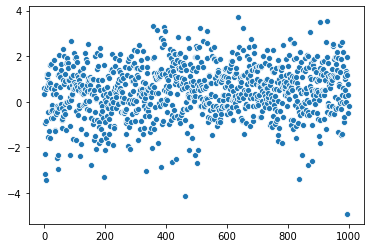

In [3]:
reward_at_time, choice_at_time, estimates = do_run(
    K=K, 
    epsilon=epsilon, 
    num_timesteps=num_timesteps
)

# Note that for a given run, things are quite noisy!
sns.scatterplot(x=np.arange(len(reward_at_time)), y=reward_at_time)

In [7]:
# Do lots of runs and average...
reward_at_times_list = []
for i in tqdm(range(num_runs)):
    reward_at_time, choice_at_time, estimates = do_run(
        K=K,
        epsilon=0.1,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_eps_01 = np.mean(reward_at_times, axis=0)

100%|██████████| 2000/2000 [05:05<00:00,  6.55it/s]


In [5]:
# Do greedy (epsilon = 0)
reward_at_times_list = []
for i in tqdm(range(num_runs)):
    reward_at_time, choice_at_time, estimates = do_run(
        K=K,
        epsilon=0.0,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_greedy = np.mean(reward_at_times, axis=0)

# epsilon = 0.01
reward_at_times_list = []
for i in tqdm(range(num_runs)):
    reward_at_time, choice_at_time, estimates = do_run(
        K=K,
        epsilon=0.01,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_eps_001 = np.mean(reward_at_times, axis=0)

100%|██████████| 2000/2000 [05:38<00:00,  5.91it/s]


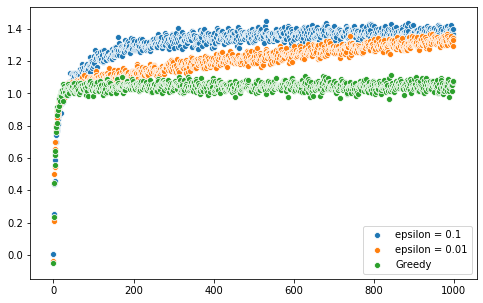

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
times = np.arange(len(mean_reward_at_times_eps_01))
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_eps_01,
    ax=ax,
    label='epsilon = 0.1'
)
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_eps_001,
    ax=ax,
    label='epsilon = 0.01'
)
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_greedy,
    ax=ax,
    label='Greedy'
)

## Optimistic initial values
We can use this to force exploration early on even if we are doing full greedy...

In [40]:
reward_at_times_list = []
#for i in tqdm(range(num_runs)):
for i in range(num_runs):
    reward_at_time, choice_at_time, estimates = do_run(
        K=K,
        epsilon=0.0,
        num_timesteps=num_timesteps,
        init_value=1.,
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_optimistic = np.mean(reward_at_times, axis=0)

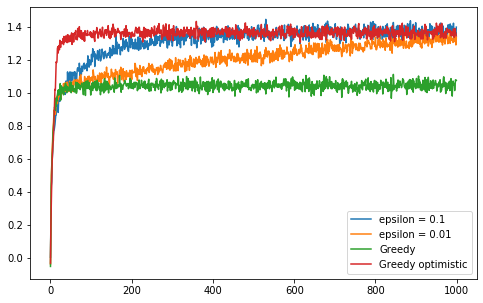

In [44]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
times = np.arange(len(mean_reward_at_times_eps_01))
sns.lineplot(
    x=times,
    y=mean_reward_at_times_eps_01,
    ax=ax,
    label='epsilon = 0.1'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_eps_001,
    ax=ax,
    label='epsilon = 0.01'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_greedy,
    ax=ax,
    label='Greedy'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_optimistic,
    ax=ax,
    label='Greedy optimistic'
)

So optimistic initialization turns out to work pretty well!  But it does require tuning or it can do a lot worse, so not sure how practical it is... 

## Upper Confidence Bound
Basically, greedy but incorporating uncertainty of the estimates so that you are more likely to try out very uncertain actions...  Specifically, your estimates are: 

$$
A(t) = argmax_a \left[ Q_t(a) + c \sqrt{\frac{\log t}{N_t(a)}} \right]
$$

This has some nice statistical properties (minimizing regret, which isn't talked about in this treatment but you'll find that used in online learning texts).

In [11]:
def do_ucb_run(K, num_timesteps, c, init_value=0.):
    """
    Do a single run of num_timesteps using the suppied epsilon and initial estimate.
    Return observed rewards, along with choice at each time step, and reward at
    each timestep.
    """
    # Set up list of rewards for each arm.
    rewards, means = sample_rewards(K=K)
    num_tries = np.zeros(K) + 1 # This is a cheat to get around treating 0's in the denominator as a special case
    estimates = np.array([init_value]  * K)

    reward_at_time = []
    choice_at_time = []
    
    for t in range(num_timesteps):
        new_estimates = estimates + c * np.sqrt(np.log(t+1) / num_tries)
        max_estimate = np.max(new_estimates)
        optimal_choices = np.where(new_estimates == max_estimate)[0]
        this_choice = np.random.choice(optimal_choices)
        
        # Evaluate this choice
        this_reward = rewards[this_choice].rvs(1)
        
        # Update estimate for this choice.
        num_tries[this_choice] += 1
        step_size = 1. / num_tries[this_choice]
        estimates[this_choice] += step_size * (this_reward - estimates[this_choice]) 
        
        choice_at_time.append(this_choice)
        reward_at_time.append(this_reward)
        
    reward_at_time = np.squeeze(np.array(reward_at_time))
    choice_at_time = np.squeeze(np.array(choice_at_time))
    return reward_at_time, choice_at_time, estimates

In [12]:
reward_at_times_list = []
for i in tqdm(range(num_runs)):
    reward_at_time, choice_at_time, estimates = do_ucb_run(
        K=K,
        num_timesteps=num_timesteps,
        c=2.,
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_ucb = np.mean(reward_at_times, axis=0)

100%|██████████| 2000/2000 [04:54<00:00,  6.79it/s]


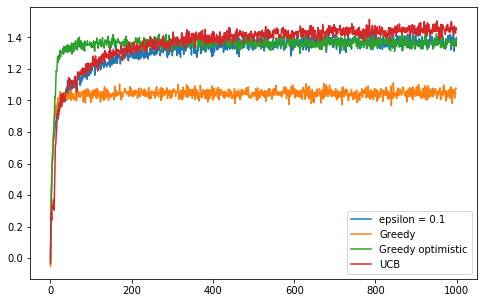

In [45]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
times = np.arange(len(mean_reward_at_times_eps_01))
sns.lineplot(
    x=times,
    y=mean_reward_at_times_eps_01,
    ax=ax,
    label='epsilon = 0.1'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_greedy,
    ax=ax,
    label='Greedy'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_optimistic,
    ax=ax,
    label='Greedy optimistic'
)
sns.lineplot(
    x=times,
    y=mean_reward_at_times_ucb,
    ax=ax,
    label='UCB'
)

# Some exercises

### Exercise 2.4
Say we have a sequence of step sizes, $\alpha_n$; in the general case, what is the weighting on each prior reward?
$$
\begin{align}
Q_{n+1} & = Q_n + \alpha_n \left[ R_n - Q_n \right] \\
& = \alpha_n R_n + (1 - \alpha_n) Q_n  \\
& = \alpha_n R_n + (1 - \alpha_n) (\alpha_{n-1} R_{n-1} + (1 - \alpha_{n-1}) Q_{n-1})) \\
& = \sum_{i = 1}^{n} \alpha_i R_i (\prod_{j=1}^{n-i} (1 - \alpha_{n-j+1})) + \prod_{j=1}^n (1 - \alpha_j) Q_1
\end{align}
$$


### Exercise 2.7 The unbiased constant step size trick
In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of: 

$$ \beta_n = \frac{\alpha}{\bar{o}_n} $$

to process the $n$th reward for a particular action, where $\alpha > 0$ is a constant step size, and $\bar{o}_n$ is a varying factor that starts at 0: 

$$ \bar{o}_n = \bar{o}_{n-1} + \alpha (1 - \bar{o}_{n-1}) \forall n \ge 0, \bar{o}_0 = 0 $$

Carry out an analysis as in (2.6) to show that $Q_n$ is an exponential recency-weighted average without initial bias.

#### Answer
First, note that $beta_n$ is just another series of step sizes, so use the general result from exercise 2.4:

$$
Q_{n+1} = \sum_{i = 1}^{n} \beta_i R_i (\prod_{j=1}^{n-i} (1 - \beta_{n-j+1})) + \prod_{j=1}^n (1 - \beta_j) Q_1
$$

Note that $0 \le \beta_n \le 1$, so this is an exponential recency weighted average. 

Now for the without bias part.  I am not sure what this means, precisely... But at a guess, it means that the $Q_1$ term disappears.  I am not sure why you wouldn't just use $Q_1 = 0$ but I guess you also want to be able to use optimistic initial values, etc... So what is that product? Note that 
$$
\begin{align}
\bar{o}_1 & = \bar{o}_0 + \alpha (1 - \bar{o}_0) \\
& = 0 + \alpha \\
& = \alpha \\
\end{align}
$$

so $\beta_1 = \frac{\alpha}{\bar{o}_1} = 1$.  Thus the product $\prod_{j=1}^n (1 - \beta_j) = 0$, so the $Q_1$ term is multiplied by $0$ and we have an unbiased estimator.


### Exercise 2.10 
Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 0.1 and 0.2 with probability 0.5 (case A), and 0.9 and 0.8 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expectation of success you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expectation of success you can achieve in this task, and how should you behave to achieve it?

#### Answer
So it sure seems like, in the absence of information about which state we are in at each time step, the best we can do is treat it like it is - each action has an associated mixture distribution, and as given the overall expected values (values) are simply 0.5 and 0.5.  Thus, the best we can do is 0.5.  

If, however, an oracle tells us which state we are in, then we can do a bit better and get an expected reward of 0.55 (we pick action 1 if case B since 0.9 > 0.8, and action 2 if in case A since 0.2 > 0.1).  